### Use this Jupyter Notebook as a guide to run your trained model in inference mode

created by Anton Morgunov

inspired by [tensorflow object detection API tutorial](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#exporting-a-trained-model)

Your first step is going to specify which unit you are going to work with for inference. Select between GPU or CPU and follow the below instructions for implementation.

In [1]:
import os # importing OS in order to make GPU visible
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # do not change anything in here

# specify which device you want to work on.
# Use "-1" to work on a CPU. Default value "0" stands for the 1st GPU that will be used
os.environ["CUDA_VISIBLE_DEVICES"]="0" # TODO: specify your computational device

In [2]:
import tensorflow as tf # import tensorflow

# checking that GPU is found
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


In [3]:
# other import
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tqdm import tqdm

Next you will import import scripts that were already provided by Tensorflow API. **Make sure that Tensorflow is your current working directory.**

In [4]:
import sys # importyng sys in order to access scripts located in a different folder

path2scripts = r'C:\Test\tfaadhar\models\research' # TODO: provide pass to the research folder
sys.path.insert(0, path2scripts) # making scripts in models/research available for import

In [5]:
# importing all scripts that will be needed to export your model and use it for inference
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

Now you can import and build your trained model:

In [10]:
# NOTE: your current working directory should be Tensorflow.

# TODO: specify two pathes: to the pipeline.config file and to the folder with trained model.
path2config =r'C:\Test\data_ext\aadhar\created_model\v1fasterrcnn\pipeline.config'
path2model = r'C:\Test\data_ext\aadhar\created_model\v1fasterrcnn\exported_model\checkpoint'

In [11]:
# do not change anything in this cell
configs = config_util.get_configs_from_pipeline_file(path2config) # importing config
model_config = configs['model'] # recreating model config
detection_model = model_builder.build(model_config=model_config, is_training=False) # importing model

In [12]:
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(path2model, 'ckpt-0')).expect_partial()

Next, path to label map should be provided. Category index will be created based on labal map file

In [13]:
path2label_map = r'C:\Test\data_ext\aadhar\test_aadhar.v2i.tfrecord\train\tags_label_map.pbtxt' # TODO: provide a path to the label map file
category_index = label_map_util.create_category_index_from_labelmap(path2label_map,use_display_name=True)

Now, a few supporting functions will be defined

In [14]:
def detect_fn(image):
    """
    Detect objects in image.
    
    Args:
      image: (tf.tensor): 4D input image
      
    Returs:
      detections (dict): predictions that model made
    """

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections

In [15]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      numpy array with shape (img_height, img_width, 3)
    """
    
    return np.array(Image.open(path))

**Next function is the one that you can use to run inference and plot results an an input image:**

Next, we will define a few other supporting functions:

In [16]:
def nms(rects, thd=0.5):
    """
    Filter rectangles
    rects is array of oblects ([x1,y1,x2,y2], confidence, class)
    thd - intersection threshold (intersection divides min square of rectange)
    """
    out = []

    remove = [False] * len(rects)

    for i in range(0, len(rects) - 1):
        if remove[i]:
            continue
        inter = [0.0] * len(rects)
        for j in range(i, len(rects)):
            if remove[j]:
                continue
            inter[j] = intersection(rects[i][0], rects[j][0]) / min(square(rects[i][0]), square(rects[j][0]))

        max_prob = 0.0
        max_idx = 0
        for k in range(i, len(rects)):
            if inter[k] >= thd:
                if rects[k][1] > max_prob:
                    max_prob = rects[k][1]
                    max_idx = k

        for k in range(i, len(rects)):
            if (inter[k] >= thd) & (k != max_idx):
                remove[k] = True

    for k in range(0, len(rects)):
        if not remove[k]:
            out.append(rects[k])

    boxes = [box[0] for box in out]
    scores = [score[1] for score in out]
    classes = [cls[2] for cls in out]
    return boxes, scores, classes


def intersection(rect1, rect2):
    """
    Calculates square of intersection of two rectangles
    rect: list with coords of top-right and left-boom corners [x1,y1,x2,y2]
    return: square of intersection
    """
    x_overlap = max(0, min(rect1[2], rect2[2]) - max(rect1[0], rect2[0]));
    y_overlap = max(0, min(rect1[3], rect2[3]) - max(rect1[1], rect2[1]));
    overlapArea = x_overlap * y_overlap;
    return overlapArea


def square(rect):
    """
    Calculates square of rectangle
    """
    return abs(rect[2] - rect[0]) * abs(rect[3] - rect[1])

**Next function is the one that you can use to run inference and save results into a file:**

In [43]:
 """
Function that performs inference and return filtered predictions

Args:
  path2images: an array with pathes to images
  box_th: (float) value that defines threshold for model prediction. Consider 0.25 as a value.
  nms_th: (float) value that defines threshold for non-maximum suppression. Consider 0.5 as a value.
  to_file: (boolean). When passed as True => results are saved into a file. Writing format is
  path2image + (x1abs, y1abs, x2abs, y2abs, score, conf) for box in boxes
  data: (str) name of the dataset you passed in (e.g. test/validation)
  path2dir: (str). Should be passed if path2images has only basenames. If full pathes provided => set False.

Returs:
  detections (dict): filtered predictions that model made
"""
    
def inference_as_raw_output(path2images,box_th = 0.25,nms_th = 0.5,to_file = False,data = None,path2dir = False):

    #print (f'Current data set is {data}')
    #print (f'Ready to start inference on {len(path2images)} images!')

    for image_path in tqdm(path2images):

        if path2dir: # if a path to a directory where images are stored was passed in
            image_path = os.path.join(path2dir, image_path.strip())

        image_np = load_image_into_numpy_array(image_path)

        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)

        # checking how many detections we got
        num_detections = int(detections.pop('num_detections'))

        # filtering out detection in order to get only the one that are indeed detections
        detections = {key: value[0, :num_detections].numpy() for key, value in detections.items()}

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        # defining what we need from the resulting detection dict that we got from model output
        key_of_interest = ['detection_classes', 'detection_boxes', 'detection_scores']

        # filtering out detection dict in order to get only boxes, classes and scores
        detections = {key: value for key, value in detections.items() if key in key_of_interest}

        if box_th: # filtering detection if a confidence threshold for boxes was given as a parameter
            for key in key_of_interest:
                scores = detections['detection_scores']
                current_array = detections[key]
                filtered_current_array = current_array[scores > box_th]
                detections[key] = filtered_current_array

        if nms_th: # filtering rectangles if nms threshold was passed in as a parameter
            # creating a zip object that will contain model output info as
            output_info = list(zip(detections['detection_boxes'],
                                   detections['detection_scores'],
                                   detections['detection_classes']
                                  )
                              )
            boxes, scores, classes = nms(output_info)
            class_dic={1:"address",2:'dob',3:'enrol_number',4:'father',5:'gender',6:'husband',7:'image',8:'mother',9:'name',10:'number'}
            detections['detection_boxes'] = boxes # format: [y1, x1, y2, x2]
            detections['detection_scores'] = scores
            detections['detection_classes'] = classes
            data_list=[]
            image_h, image_w, _ = image_np.shape
            for b, s, c in zip(boxes, scores, classes):

                    y1abs, x1abs = b[0] * image_h, b[1] * image_w
                    y2abs, x2abs = b[2] * image_h, b[3] * image_w

                    data_list.append([x1abs, y1abs, x2abs, y2abs, s, class_dic[c]])
            
       
        if to_file and data: # if saving to txt file was requested

            image_h, image_w, _ = image_np.shape
            file_name = "C:\Test\data_ext\aadhar\test_infer\test.txt"

            line2write = list()
            line2write.append(os.path.basename(image_path))

            with open(file_name, 'w+') as text_file:
                # iterating over boxes
                for b, s, c in zip(boxes, scores, classes):

                    y1abs, x1abs = b[0] * image_h, b[1] * image_w
                    y2abs, x2abs = b[2] * image_h, b[3] * image_w

                    list2append = [x1abs, y1abs, x2abs, y2abs, s, c]
                    line2append = ','.join([str(item) for item in list2append])

                    line2write.append(line2append)

                line2write = ' '.join(line2write)
                text_file.write(line2write + os.linesep)

        return data_list #detections
    
%matplotlib inline
path2images=['C:/Test/data_ext/aadhar/test_infer/val3.jpg']
print(inference_as_raw_output(path2images))

  0%|                                                                                                          | 0/1 [00:00<?, ?it/s]

[[80.56001782417297, 174.76695030927658, 349.99845266342163, 484.2227590084076, 0.9999975, 'husband'], [337.986102104187, 500.7005989551544, 696.1337614059448, 551.7330121994019, 0.99999404, 'name'], [360.44273376464844, 193.4868022799492, 505.7733154296875, 271.70022904872894, 0.9999875, 'mother'], [347.70071268081665, 287.11873412132263, 731.0877752304077, 323.8615518808365, 0.9999541, 'address'], [351.4287829399109, 326.3994598388672, 549.5009183883667, 358.52424144744873, 0.99873465, 'father']]


Running inference for C:/Test/data_ext/aadhar/test_infer/val3.jpg... Done


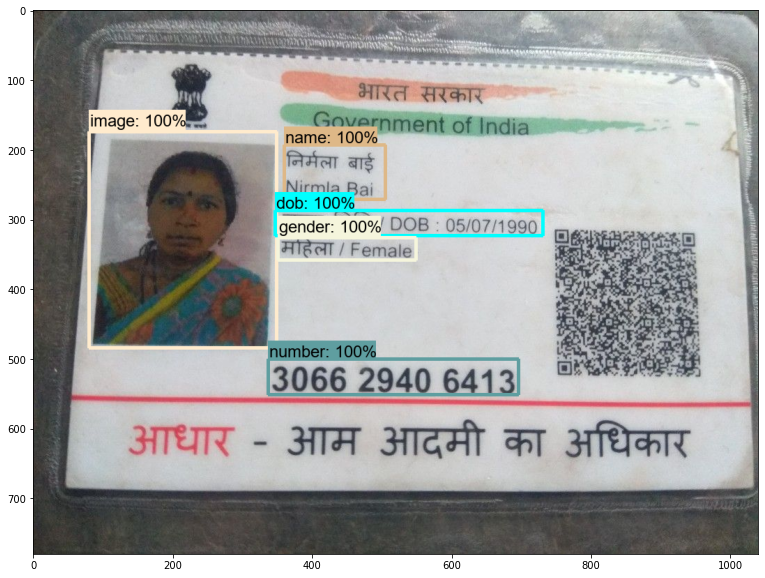

{'detection_boxes': array([[0.2240602 , 0.07746156, 0.6207984 , 0.33653697],
       [0.64192384, 0.32498664, 0.70735   , 0.6693594 ],
       [0.24806   , 0.34657955, 0.34833363, 0.4863205 ],
       ...,
       [0.42050803, 0.43692714, 0.4598062 , 0.52303404],
       [0.29005903, 0.17668307, 0.3981696 , 0.26948544],
       [0.28005546, 0.32613298, 0.8444845 , 0.69168234]], dtype=float32), 'detection_scores': array([9.99997497e-01, 9.99994040e-01, 9.99987483e-01, 9.99954104e-01,
       9.98734653e-01, 1.50506874e-03, 5.71877987e-04, 5.21726848e-04,
       4.23714053e-04, 3.44865548e-04, 3.14537436e-04, 2.96982122e-04,
       2.65988900e-04, 2.28427540e-04, 1.93763495e-04, 1.51022963e-04,
       1.16099422e-04, 1.07676788e-04, 9.66793377e-05, 9.18994265e-05,
       8.35348546e-05, 7.19394811e-05, 6.87711581e-05, 5.58415959e-05,
       4.93058287e-05, 4.87003745e-05, 4.51023407e-05, 4.47903731e-05,
       3.12963966e-05, 3.03210545e-05, 2.69199736e-05, 2.53758517e-05,
       2.37389468e-05

In [19]:
def inference_with_plot(path2images, box_th=0.25):
    """
    Function that performs inference and plots resulting b-boxes
    
    Args:
      path2images: an array with pathes to images
      box_th: (float) value that defines threshold for model prediction.
      
    Returns:
      None
    """
    for image_path in path2images:

        print('Running inference for {}... '.format(image_path), end='')

        image_np = load_image_into_numpy_array(image_path)
        
        input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
        detections = detect_fn(input_tensor)

        # All outputs are batches tensors.
        # Convert to numpy arrays, and take index [0] to remove the batch dimension.
        # We're only interested in the first num_detections.
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                      for key, value in detections.items()}
        
        detections['num_detections'] = num_detections

        ions['detection_classes'] = detections['detection_classes'].astype(np.int64)

        label_id_offset = 1
        image_np_with_detections = image_np.copy()

        viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=200,
                min_score_thresh=box_th,
                agnostic_mode=False,
                line_thickness=5)

        plt.figure(figsize=(15,10))
        plt.imshow(image_np_with_detections)
        print('Done')
    plt.show()
    print(detections)

%matplotlib inline    
path2images=['C:/Test/data_ext/aadhar/test_infer/val3.jpg']
inference_with_plot(path2images)